# 0. import the necessary packages

In [2]:
import numpy as np
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import warnings
from pandas.core.common import SettingWithCopyWarning
from pandas_profiling import ProfileReport
from pathlib import Path
from scipy.stats import probplot, chi2_contingency, chi2
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, cross_val_predict
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, OrdinalEncoder
from sklearn.inspection import permutation_importance
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, roc_curve, roc_auc_score
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier, AdaBoostClassifier, VotingClassifier, ExtraTreesClassifier, StackingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from imblearn.over_sampling import SMOTE
import joblib
%matplotlib inline

# 1. Get the data

In [3]:
cc_data_full_data = pd.read_csv('dataset/application_record.csv')
credit_status = pd.read_csv('dataset/credit_record.csv')

In [4]:
# creating the target variable
begin_month=pd.DataFrame(credit_status.groupby(["ID"])["MONTHS_BALANCE"].agg(min))
begin_month=begin_month.rename(columns={'MONTHS_BALANCE':'Account age'})
cc_data_full_data=pd.merge(cc_data_full_data,begin_month,how="left",on="ID")
credit_status['dep_value'] = None
credit_status['dep_value'][credit_status['STATUS'] =='2']='Yes'
credit_status['dep_value'][credit_status['STATUS'] =='3']='Yes'
credit_status['dep_value'][credit_status['STATUS'] =='4']='Yes'
credit_status['dep_value'][credit_status['STATUS'] =='5']='Yes'
cpunt=credit_status.groupby('ID').count()
cpunt['dep_value'][cpunt['dep_value'] > 0]='Yes'
cpunt['dep_value'][cpunt['dep_value'] == 0]='No'
cpunt = cpunt[['dep_value']]
cc_data_full_data = pd.merge(cc_data_full_data,cpunt,how='inner',on='ID')
cc_data_full_data['Is high risk']=cc_data_full_data['dep_value']
cc_data_full_data.loc[cc_data_full_data['Is high risk']=='Yes','Is high risk']=1
cc_data_full_data.loc[cc_data_full_data['Is high risk']=='No','Is high risk']=0
cc_data_full_data.drop('dep_value',axis=1,inplace=True)
warnings.simplefilter(action="always", category=SettingWithCopyWarning)

In [5]:
# change the account in months
cc_data_full_data['Account age'] = np.abs(cc_data_full_data['Account age']).astype('int32')

In [6]:
# rename the columns to a more readable format
cc_data_full_data = cc_data_full_data.rename(columns={
    'CODE_GENDER':'Gender',
    'FLAG_OWN_CAR':'Has a car',
    'FLAG_OWN_REALTY':'Has a property',
    'CNT_CHILDREN':'Children count',
    'AMT_INCOME_TOTAL':'Income',
    'NAME_INCOME_TYPE':'Employment',
    'NAME_EDUCATION_TYPE':'Education level',
    'NAME_FAMILY_STATUS':'Marital status',
    'NAME_HOUSING_TYPE':'dwelling',
    'DAYS_BIRTH':'Age in days',
    'DAYS_EMPLOYED': 'Employment lenght in days',
    'FLAG_MOBIL': 'Has a mobile phone',
    'FLAG_WORK_PHONE': 'Has a work phone',
    'FLAG_PHONE': 'Has a phone',
    'FLAG_EMAIL': 'Has an email',
    'OCCUPATION_TYPE': 'Job title',
    'CNT_FAM_MEMBERS': 'Family member count',
    'Account age': 'Account age in months'
})

In [7]:
# split the data into train and test
def data_split(df, test_size):
    train_df, test_df = train_test_split(df, test_size=test_size, random_state=42)
    return train_df.reset_index(drop=True), test_df.reset_index(drop=True)

In [8]:
cc_train_original, cc_test_original = data_split(cc_data_full_data, 0.2)

In [9]:
cc_train_original.shape

(29165, 20)

In [10]:
cc_test_original.shape

(7292, 20)

# Explore the Data

In [11]:
# creating a copy of the dataset so that the original stays untouched
cc_train_copy = cc_train_original.copy()
cc_test_copy = cc_test_original.copy()

In [12]:
cc_train_copy.head()

,ID,Gender,Has a car,Has a property,Children count,Income,Employment,Education level,Marital status,dwelling,Age in days,Employment lenght in days,Has a mobile phone,Has a work phone,Has a phone,Has an email,Job title,Family member count,Account age in months,Is high risk
0,5037048,M,Y,Y,0,135000.0,Working,Secondary / secondary special,Married,With parents,-16271,-3111,1,0,0,0,Core staff,2.0,17,0
1,5044630,F,Y,N,1,135000.0,Commercial associate,Higher education,Single / not married,House / apartment,-10130,-1651,1,0,0,0,Accountants,2.0,1,0
2,5079079,F,N,Y,2,180000.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-12821,-5657,1,0,0,0,Laborers,4.0,38,0
3,5112872,F,Y,Y,0,360000.0,Commercial associate,Higher education,Single / not married,House / apartment,-20929,-2046,1,0,0,1,Managers,1.0,11,0
4,5105858,F,N,N,0,270000.0,Working,Secondary / secondary special,Separated,House / apartment,-16207,-515,1,0,1,0,NaN,1.0,41,0


In [13]:
cc_train_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29165 entries, 0 to 29164
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   ID                         29165 non-null  int64  
 1   Gender                     29165 non-null  object 
 2   Has a car                  29165 non-null  object 
 3   Has a property             29165 non-null  object 
 4   Children count             29165 non-null  int64  
 5   Income                     29165 non-null  float64
 6   Employment                 29165 non-null  object 
 7   Education level            29165 non-null  object 
 8   Marital status             29165 non-null  object 
 9   dwelling                   29165 non-null  object 
 10  Age in days                29165 non-null  int64  
 11  Employment lenght in days  29165 non-null  int64  
 12  Has a mobile phone         29165 non-null  int64  
 13  Has a work phone           29165 non-null  int

In [14]:
cc_train_copy.describe()

,ID,Children count,Income,Age in days,Employment lenght in days,Has a mobile phone,Has a work phone,Has a phone,Has an email,Family member count,Account age in months
count,2.916500e+04,29165.000000,2.916500e+04,29165.000000,29165.000000,29165.0,29165.000000,29165.000000,29165.000000,29165.000000,29165.000000
mean,5.078232e+06,0.430790,1.868904e+05,-15979.477490,59257.761255,1.0,0.224310,0.294977,0.090279,2.197531,26.137734
std,4.182400e+04,0.741882,1.014096e+05,4202.997485,137655.883458,0.0,0.417134,0.456040,0.286587,0.912189,16.486702
min,5.008804e+06,0.000000,2.700000e+04,-25152.000000,-15713.000000,1.0,0.000000,0.000000,0.000000,1.000000,0.000000
25%,5.042047e+06,0.000000,1.215000e+05,-19444.000000,-3153.000000,1.0,0.000000,0.000000,0.000000,2.000000,12.000000
50%,5.074666e+06,0.000000,1.575000e+05,-15565.000000,-1557.000000,1.0,0.000000,0.000000,0.000000,2.000000,24.000000
75%,5.114629e+06,1.000000,2.250000e+05,-12475.000000,-412.000000,1.0,0.000000,1.000000,0.000000,3.000000,39.000000
max,5.150485e+06,19.000000,1.575000e+06,-7705.000000,365243.000000,1.0,1.000000,1.000000,1.000000,20.000000,60.000000


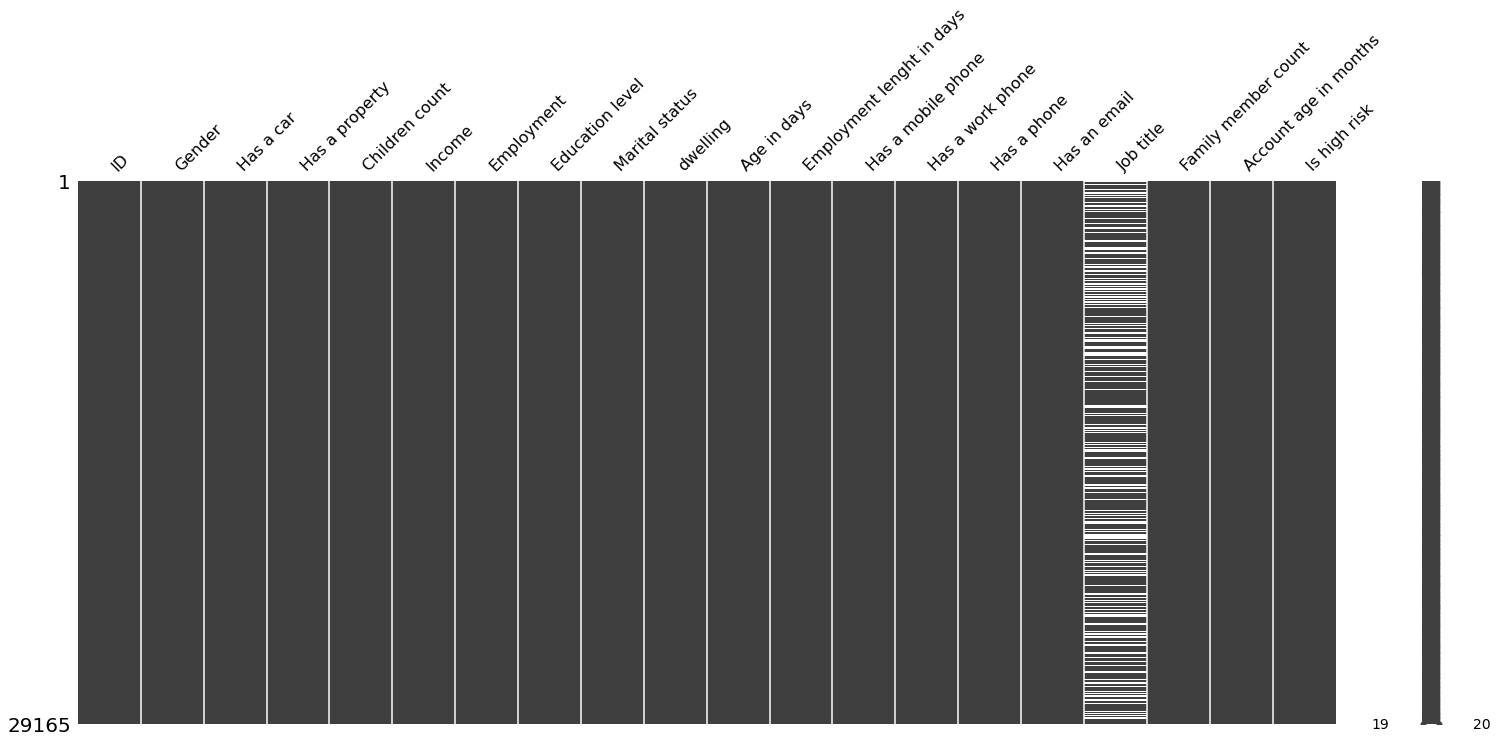

In [15]:
msno.matrix(cc_train_copy)
plt.show()

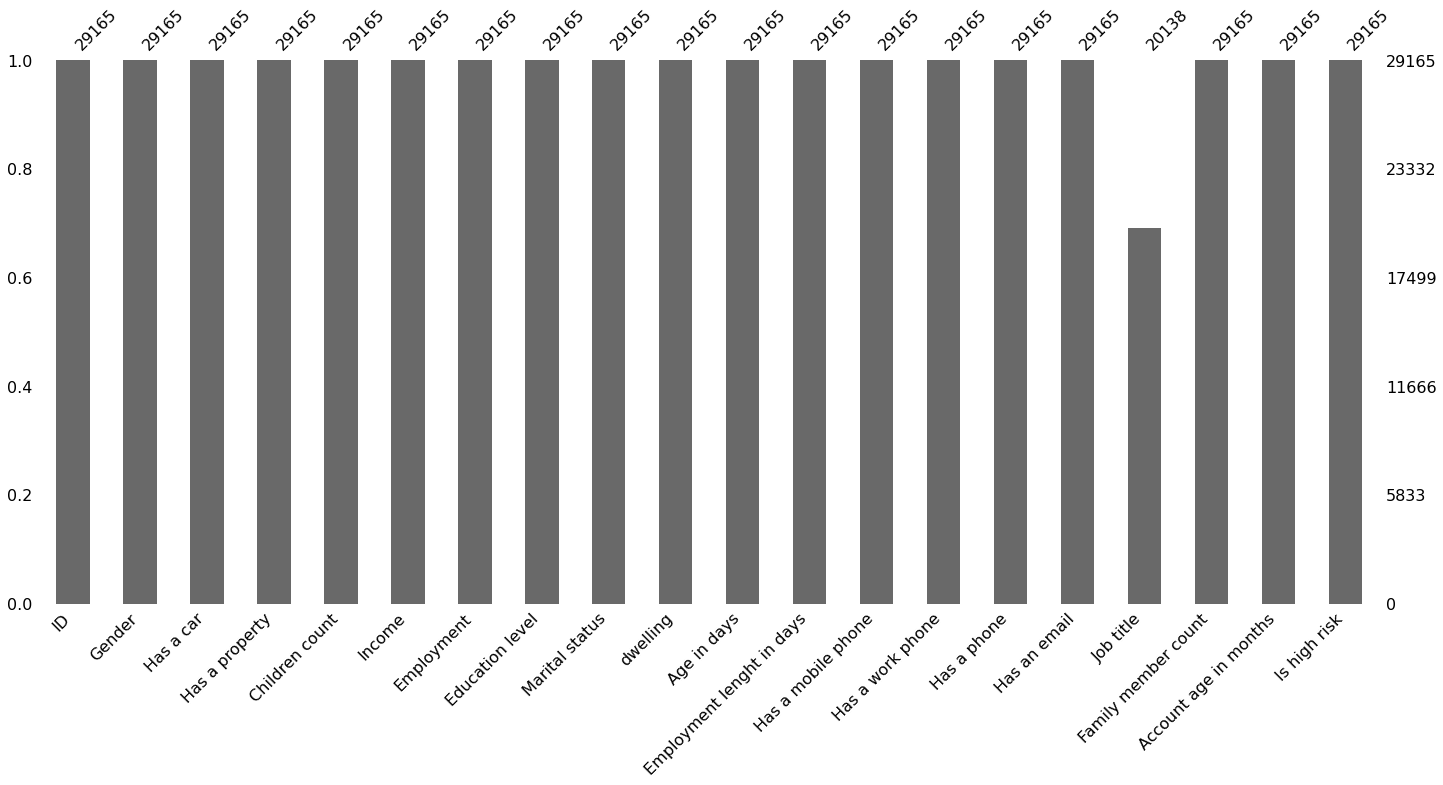

In [16]:
msno.bar(cc_train_copy)
plt.show()

In [17]:
#Function that will return the value count and frequency of each observation within a column
def value_cnt_norm_cal(df,feature):
    ftr_value_cnt = df[feature].value_counts()
    ftr_value_cnt_norm = df[feature].value_counts(normalize=True) * 100
    ftr_value_cnt_concat = pd.concat([ftr_value_cnt, ftr_value_cnt_norm], axis=1)
    ftr_value_cnt_concat.columns = ['Count', 'Frequency (%)']
    return ftr_value_cnt_concat

In [18]:
cc_train_copy['Job title'].isna().sum()

9027

## 1. Gender

In [19]:
cc_train_copy['Gender'].describe()

count     29165
unique        2
top           F
freq      19549
Name: Gender, dtype: object

In [20]:
cc_train_copy['Gender'].dtype

dtype('O')

In [21]:
male_female_ratio_size = value_cnt_norm_cal(cc_test_copy, 'Gender')

In [22]:
male_female_ratio_size

,Count,Frequency (%)
F,4881,66.936369
M,2411,33.063631


In [23]:
male_female_ratio = male_female_ratio_size['Frequency (%)'].loc['F'], male_female_ratio_size['Frequency (%)'].loc['M']

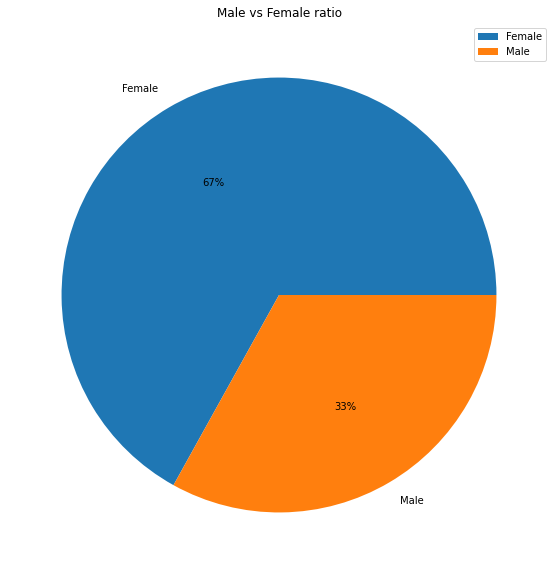

In [78]:
fig, ax = plt.subplots(figsize=(18,10))
plt.pie(male_female_ratio,labels=["Female","Male"],autopct='%1.0f%%')
plt.title('Male vs Female ratio')
plt.legend(loc='upper right')
plt.show()

In [25]:
male_female_ratio_ct = male_female_ratio_size['Count'].loc['F'], male_female_ratio_size['Count'].loc['M']

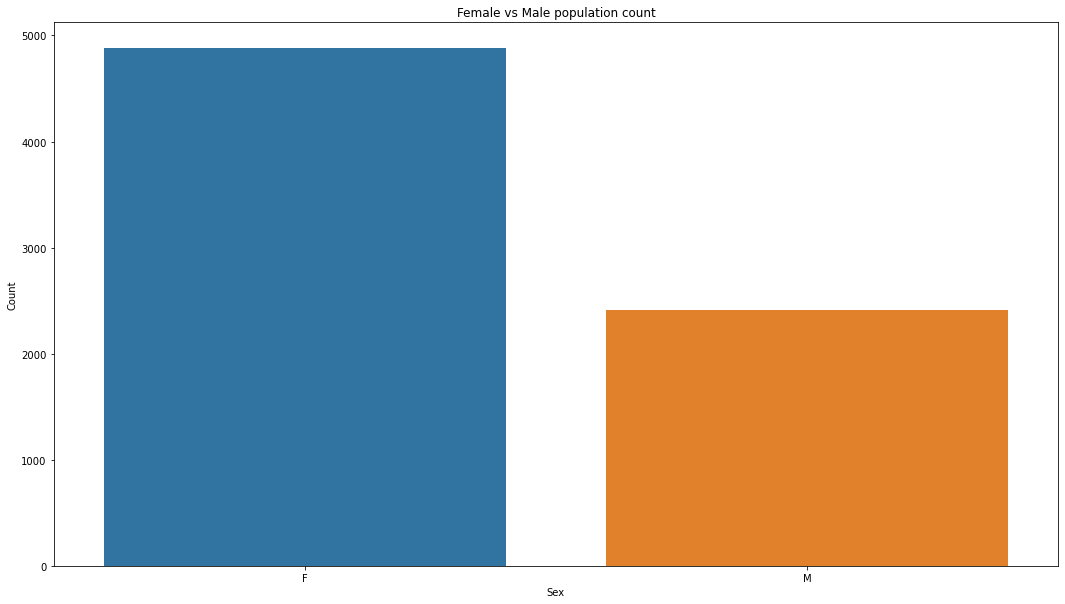

In [80]:
# Male vs Female population size
fig, ax = plt.subplots(figsize=(18,10))
sns.barplot(x=list(cc_train_copy['Gender'].value_counts().index),y=list(male_female_ratio_ct))
plt.xlabel("Sex")
plt.ylabel("Count")
plt.title('Female vs Male population count')
plt.show()

## 2. Age

In [27]:
cc_train_copy['Age in days'].describe()

count    29165.000000
mean    -15979.477490
std       4202.997485
min     -25152.000000
25%     -19444.000000
50%     -15565.000000
75%     -12475.000000
max      -7705.000000
Name: Age in days, dtype: float64

In [28]:
cc_train_copy['Age in days'].dtype

dtype('int64')

In [38]:
# let's change the age expressed in day into years
cc_train_copy['Age'] = np.abs(cc_train_copy['Age in days'])/365.25

In [42]:
np.abs(cc_train_copy['Age in days']).min()

7705

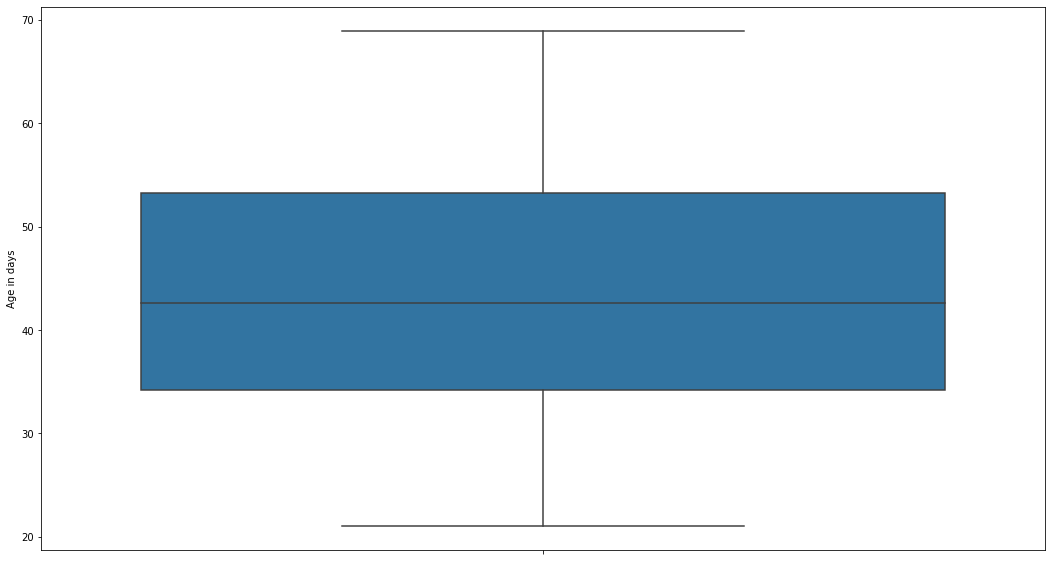

In [81]:
fig, ax = plt.subplots(figsize=(18,10))
sns.boxplot(y=np.abs(cc_train_copy['Age in days'])/365.25)
plt.show()

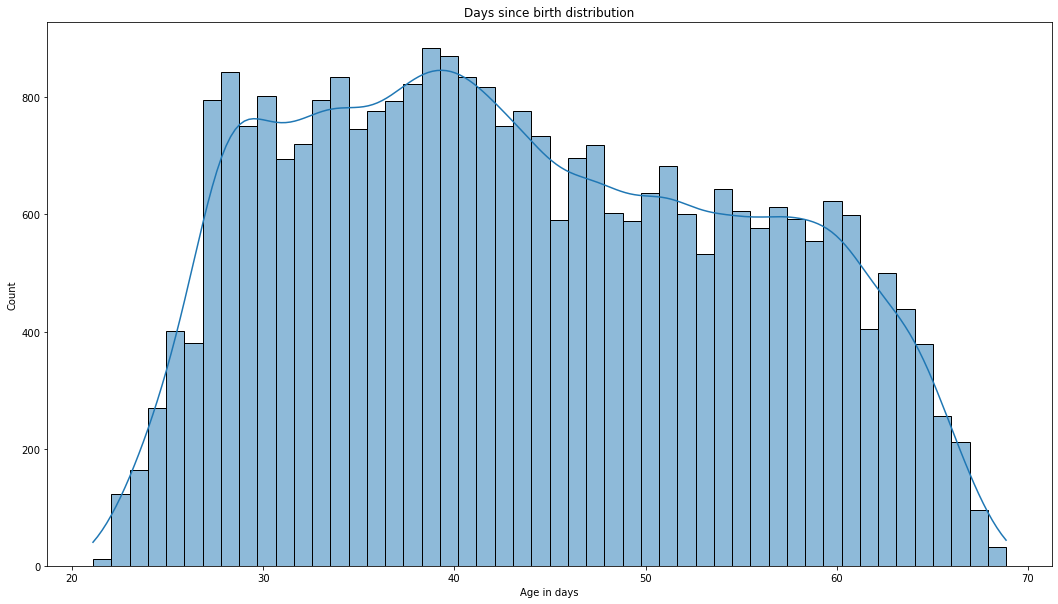

In [82]:
fig, ax = plt.subplots(figsize=(18,10))
sns.histplot(np.abs(cc_train_copy['Age in days'])/365.25,bins=50,kde=True)
plt.title('Days since birth distribution')
plt.show()

In [61]:
np.abs(cc_train_copy.groupby("Is high risk")['Age in days'].mean()/365.25)

Is high risk
0    43.753103
1    43.538148
Name: Age in days, dtype: float64

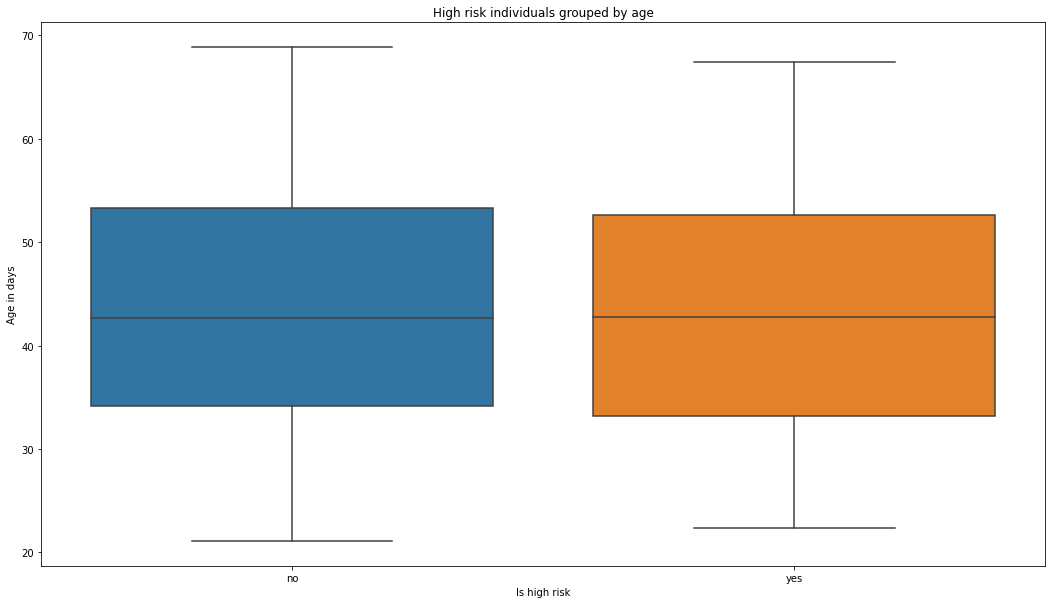

In [83]:
# High risk vs low risk applicants compared by age
fig, ax = plt.subplots(figsize=(18,10))
sns.boxplot(y=np.abs(cc_train_copy['Age in days'])/365.25,x=cc_train_copy["Is high risk"])
plt.xticks(ticks=[0,1],labels=["no","yes"])
plt.title('High risk individuals grouped by age')
plt.show()

## 3. Marital status

In [49]:
cc_train_copy['Marital status'].describe()

count       29165
unique          5
top       Married
freq        20044
Name: Marital status, dtype: object

In [50]:
cc_train_copy['Marital status'].dtype

dtype('O')

In [51]:
value_cnt_norm_cal(cc_train_copy, 'Marital status')

,Count,Frequency (%)
Married,20044,68.726213
Single / not married,3864,13.248757
Civil marriage,2312,7.927310
Separated,1712,5.870050
Widow,1233,4.227670


In [52]:
cc_train_copy['Marital status'].unique()

array(['Married', 'Single / not married', 'Separated', 'Civil marriage',
       'Widow'], dtype=object)

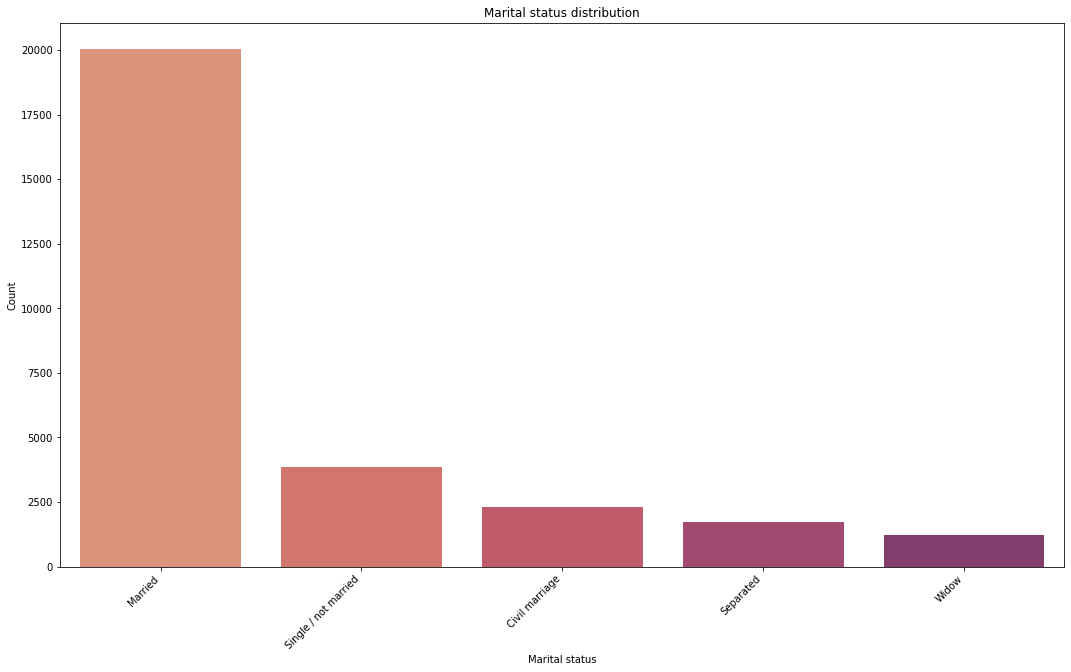

In [84]:
figfig, ax = plt.subplots(figsize=(18,10))
sns.barplot(x=cc_train_copy['Marital status'].value_counts().index,y=cc_train_copy['Marital status'].value_counts().values,palette=sns.color_palette("flare"))
ax.set_xticklabels(labels=['Married', 'Single / not married', 'Civil marriage','Separated', 'Widow'],rotation=45,ha='right')
plt.xlabel("Marital status")
plt.ylabel("Count")
plt.title('Marital status distribution')
plt.show()

In [66]:
# High risk applicants grouped by their marital status
is_high_risk_ms_grp = cc_train_copy.groupby('Marital status')['Is high risk'].sum()

In [72]:
is_high_risk_ms_grp = is_high_risk_ms_grp.sort_values(ascending=False)
is_high_risk_ms_grp

Marital status
Married                 320
Single / not married     87
Civil marriage           34
Widow                    34
Separated                24
Name: Is high risk, dtype: object

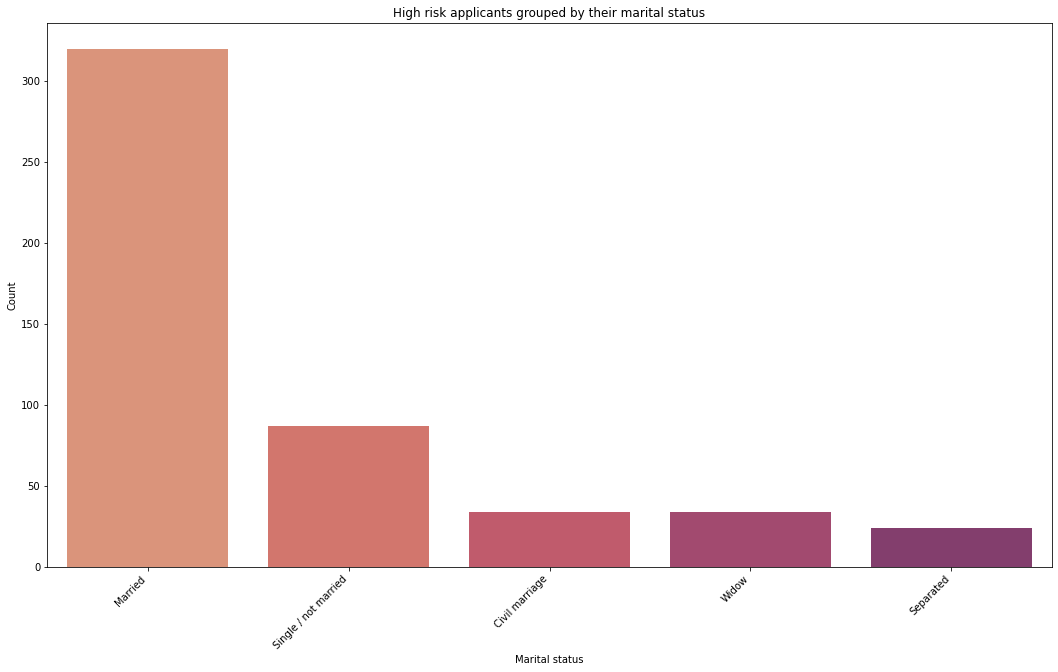

In [85]:
figfig, ax = plt.subplots(figsize=(18,10))
sns.barplot(x=is_high_risk_ms_grp.index,y=is_high_risk_ms_grp.values,palette=sns.color_palette("flare"))
ax.set_xticklabels(labels=['Married','Single / not married','Civil marriage', 'Widow', 'Separated'],rotation=45, ha="right")
plt.ylabel('Count')
plt.title('High risk applicants grouped by their marital status')
plt.show()

#### 4. Family size

In [76]:
cc_train_copy['Family member count'].describe()

count    29165.000000
mean         2.197531
std          0.912189
min          1.000000
25%          2.000000
50%          2.000000
75%          3.000000
max         20.000000
Name: Family member count, dtype: float64

#### Family size distribution

In [ ]:
sns.boxplot(y=application_train_copy['Family size'])
plt.title('Family size distribution')
plt.show()

#### High risk individual grouped by Family Size

In [ ]:
is_high_risk_fs_grp_count = application_train_copy.groupby('Family size')['Is high risk'].sum()

In [ ]:
is_high_risk_fs_grp_count

In [ ]:
fig, ax = plt.subplots()
sns.barplot(x=is_high_risk_fs_grp_count.index,y=is_high_risk_fs_grp_count.values,palette=sns.color_palette("flare"))
plt.ylabel('Count')
plt.title('Family size')
plt.show()

#### 5. Children count  

In [ ]:
application_train_copy['Children count'].describe()

In [ ]:
sns.boxplot(y=application_train_copy['Children count'])
plt.show()

#### High risk individual grouped by children count

In [ ]:
is_high_risk_cc_grp_count = application_train_copy.groupby('Children count')['Is high risk'].sum()

In [ ]:
is_high_risk_cc_grp_count

In [ ]:
fig, ax = plt.subplots()
sns.barplot(x=is_high_risk_cc_grp_count.index,y=is_high_risk_cc_grp_count.values,palette="flare")
plt.ylabel('Count')
plt.title('High risk individual grouped by children count')
plt.show()

#### 6. Way of living

In [ ]:
application_train_copy['Way of living'].describe()

In [ ]:
application_train_copy['Way of living'].unique()

In [ ]:
application_train_copy['Way of living'].value_counts()

In [ ]:
fig, ax = plt.subplots()
sns.barplot(x=application_train_copy['Way of living'].value_counts().index,y=application_train_copy['Way of living'].value_counts().values,palette=sns.color_palette('flare'))
ax.set_xticklabels(labels=application_train_copy['Way of living'].value_counts().index,rotation=45, ha="right")
plt.title('Way of living distribution')
plt.ylabel('Count')

#### High risk individuals grouped by their way of living

In [ ]:
is_high_risk_wl_grp_count = application_train_copy.groupby('Way of living')['Is high risk'].sum()

In [ ]:
is_high_risk_wl_grp_count

In [ ]:
fig, ax = plt.subplots()
sns.barplot(x=is_high_risk_wl_grp_count.index,y=is_high_risk_wl_grp_count.values,palette="flare")
plt.ylabel('Count')
ax.set_xticklabels(labels=is_high_risk_wl_grp_count.index,rotation=45, ha="right")
plt.title('High risk individual grouped by their way of living')
plt.show()

#### 7. Income

In [ ]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)
application_train_copy['Income'].describe()

In [ ]:
fig, ax = plt.subplots()
sns.boxplot(y=application_train_copy["Income"])
ax.ticklabel_format(useOffset=False, style='plain', axis='y')
plt.show()

In [ ]:
fig, ax = plt.subplots()
sns.histplot(data=application_train_copy["Income"],bins=30,kde=True)
plt.title('Income distribution')
ax.ticklabel_format(useOffset=False, style='plain', axis='x')
plt.show()

#### High risk individuals grouped by income

In [ ]:
application_train_copy.groupby("Is high risk")['Income'].mean()

In [ ]:
fig, ax = plt.subplots()
sns.boxplot(y=application_train_copy["Income"],x=application_train_copy["Is high risk"])
plt.xticks(ticks=[0,1],labels=["no","yes"])
ax.ticklabel_format(useOffset=False, style='plain', axis='y')
plt.title('High risk individuals grouped by Income')
plt.show()

#### 8. Occupation

In [ ]:
occupation_na = application_train_copy['Occupation'].isna().sum() 
occupation_na 

In [ ]:
print("The percent of missing value is {:.2f}%".format((occupation_na*100)/len(application_train_copy['Occupation'])))

In [ ]:
application_train_copy['Occupation'].value_counts()

#### Occupation vs income

In [ ]:
app_grouped_occupation_income = application_train_copy.groupby('Occupation')['Income'].mean()

In [ ]:
sns.barplot(x=app_grouped_occupation_income.index.to_list(),y=app_grouped_occupation_income.values)
plt.xticks(rotation=45, ha="right")
plt.ylabel('Income')
plt.xlabel('Occupation')
plt.title('Mean income by occupation')
plt.show()

In [ ]:
income_occ = pd.concat([application_train_copy['Occupation'],application_train_copy['Income']],axis=1)

In [ ]:
fig, ax = plt.subplots(figsize=(16,8))
sns.boxplot(x='Occupation',y='Income',data=income_occ)
plt.xticks(rotation=45,ha='right')
ax.ticklabel_format(useOffset=False, style='plain', axis='y')
plt.title('Occupation vs Income')
plt.show()

#### High risk vs income 

In [ ]:
pd.crosstab(index=application_train_copy['Is high risk'],columns=application_train_copy['Occupation'],margins=True,normalize=False)

In [ ]:
pd.crosstab(index=application_train_copy['Is high risk'],columns=application_train_copy['Occupation'],margins=True,normalize='columns') * 100

#### 9. Income category

In [ ]:
application_train_copy['Income category'].describe()

In [ ]:
application_train_copy['Income category'].value_counts()

In [ ]:
application_train_copy['Income category'].unique() 

In [ ]:
fig, ax = plt.subplots()
sns.barplot(x=application_train_copy['Income category'].value_counts().index,y=application_train_copy['Income category'].value_counts().values,palette=sns.color_palette("flare"))
plt.xlabel("Income category")
plt.xticks(rotation=45,ha='right')
plt.ylabel("Count")
plt.title('Income category distribution')
plt.show()

#### High risk individuals grouped by their Income category

In [ ]:
application_train_copy.groupby('Income category')['Is high risk'].sum()

In [ ]:
is_high_risk_ic_grp_count = application_train_copy.groupby('Income category')['Is high risk'].sum()

In [ ]:
fig, ax = plt.subplots()
sns.barplot(x=is_high_risk_ic_grp_count.index,y=is_high_risk_ic_grp_count.values,palette=sns.color_palette("flare"))
plt.ylabel('Count')
plt.xticks(rotation=45,ha='right')
plt.title('High risk individuals grouped by their income category')
plt.show()

#### 10. Education level

In [ ]:
application_train_copy['Education level'].describe()

In [ ]:
application_train_copy['Education level'].unique()

In [ ]:
application_train_copy['Education level'].value_counts()

In [ ]:
fig, ax = plt.subplots()
sns.barplot(x=application_train_copy['Education level'].value_counts().index,y=application_train_copy['Education level'].value_counts().values,palette=sns.color_palette("flare"))
ax.set_xticklabels(labels=application_train_copy['Education level'].value_counts().index.to_list(),rotation=45,ha='right')
plt.xlabel("Education level")
plt.ylabel("Count")
plt.title('Education level distribution')
plt.show()

#### 11. Days since employment (positive means unemployed)

In [ ]:
application_train_copy['Days since employment (positive means unemployed)'].describe()

#### Days since employment distribution

In [ ]:
sns.histplot(data=application_train_copy["Days since employment (positive means unemployed)"],bins=50,kde=True)
plt.title('Days since employment distribution')
plt.show()

In [ ]:
days_since_employment_no_ret = application_train_copy["Days since employment (positive means unemployed)"][application_train_copy["Days since employment (positive means unemployed)"] != 365243]

In [ ]:
sns.histplot(data=days_since_employment_no_ret,bins=50,kde=True)
plt.title('Days since employment distribution (retirement not accounted)')
plt.show()

In [ ]:
sns.boxplot(y=days_since_employment_no_ret)
plt.show()

#### 12. Has a car

In [ ]:
application_train_copy['Has a car'].describe()

In [ ]:
application_train_copy['Has a car'].value_counts()

In [ ]:
application_train_copy['Has a car'].value_counts(normalize=True) * 100

#### Car ownership ratio

In [ ]:
size_car_own = application_train_copy['Has a car'].value_counts().values
size_car_own

In [ ]:
plt.pie(size_car_own,labels=["Does not own a car","Own a car"],autopct='%1.0f%%')
plt.title('Car owner ratio')
plt.show()

#### Car ownership count

In [ ]:
sns.barplot(x=application_train_copy['Has a car'].value_counts().index,y=size_car_own)
plt.xlabel("Have a car")
plt.ylabel("Count")
plt.title('Car owner count')
plt.show()

#### 13. Has a property

In [ ]:
application_train_copy['Has a property'].describe()

In [ ]:
application_train_copy['Has a property'].value_counts()

In [ ]:
application_train_copy['Has a property'].value_counts(normalize=True) * 100

#### Property ownership ratio

In [ ]:
size_prop_own = application_train_copy['Has a property'].value_counts().values
size_prop_own

In [ ]:
plt.pie(size_prop_own,labels=["Own a property", "Does not own a property"],autopct='%1.0f%%')
plt.title('Property owner ratio')
plt.show()

#### Property ownership count

In [ ]:
sns.barplot(x=application_train_copy['Has a property'].value_counts().index,y=size_prop_own)
plt.xlabel("Have a property")
plt.ylabel("Count")
plt.title('Property owner count')
plt.show()

#### 14. Has a work phone

In [ ]:
application_train_copy['Has a work phone'].describe()

In [ ]:
application_train_copy['Has a work phone'].value_counts()

In [ ]:
application_train_copy['Has a work phone'].value_counts(normalize=True) * 100

#### Work phone ownership ratio

In [ ]:
size_work_phone = application_train_copy['Has a work phone'].value_counts().values
size_work_phone

In [ ]:
plt.pie(size_work_phone,labels=["Does not own a work phone","Own a work phone"],autopct='%1.0f%%')
plt.title('Work phone owner ratio')
plt.show()

#### Work phone  ownership count

In [ ]:
sns.barplot(x=application_train_copy['Has a work phone'].value_counts().index,y=size_work_phone)
plt.xlabel("Has a work phone")
plt.ylabel("Count")
plt.title('Work phone owner count')
plt.show()

#### 15. Has a mobile phone

In [ ]:
application_train_copy['Has a mobile phone']

In [ ]:
application_train_copy['Has a mobile phone'].unique()

In [ ]:
application_train_copy['Has a mobile phone'].value_counts()

In [ ]:
size_mobile_own = application_train_copy['Has a mobile phone'].value_counts().values
size_mobile_own
plt.pie(size_mobile_own,labels=["Own a mobile phone"],autopct='%1.0f%%')
plt.title('Mobile owner ratio')
plt.show()

#### 16. Has a phone

In [ ]:
application_train_copy['Has a phone'].value_counts(normalize=True) * 100

#### Phone ownership ratio

In [ ]:
size_phone_own = application_train_copy['Has a phone'].value_counts().values
size_phone_own

In [ ]:
plt.pie(size_phone_own,labels=["Does not own a phone","Own a phone"],autopct='%1.0f%%')
plt.title('Phone owner ratio')
plt.show()

#### Phone ownership count

In [ ]:
sns.barplot(x=application_train_copy['Has a phone'].value_counts().index,y=size_phone_own)
plt.xlabel("Has a phone")
plt.ylabel("Count")
plt.title('Phone owner count')
plt.show()

#### 17. Has an email

In [ ]:
application_train_copy['Has an email'].value_counts()

In [ ]:
application_train_copy['Has an email'].value_counts()

In [ ]:
application_train_copy['Has an email'].value_counts(normalize=True) * 100

#### Email ownership ratio

In [ ]:
size_email_own = application_train_copy['Has an email'].value_counts().values
size_email_own

In [ ]:
plt.pie(size_email_own,labels=["Does not have an email","Have an email"],autopct='%1.0f%%')
plt.title('Email owner ratio')
plt.show()

#### Email ownership count

In [ ]:
sns.barplot(x=application_train_copy['Has an email'].value_counts().index,y=size_email_own)
plt.xlabel("Has an email")
plt.ylabel("Count")
plt.title('Car owner count')
plt.show()

#### 4. For supervised learning tasks, identify the target attribute(s).

The target 'Is high risk'

#### Target analysis

In [ ]:
high_risk_count = application_train_copy['Is high risk'].value_counts()
high_risk_count 

In [ ]:
high_risk_ratio = application_train_copy['Is high risk'].value_counts(normalize=True) * 100
high_risk_ratio 

In [ ]:
plt.pie(high_risk_ratio,labels=["No","Yes"],autopct='%1.0f%%')
plt.title('High risk ratio')
plt.show()

In [ ]:
fig, ax = plt.subplots()
sns.barplot(x=high_risk_count.index,y=high_risk_count.values)
ax.set_xticklabels(['No','Yes'])
plt.xlabel("High risk")
plt.ylabel("Count")
plt.title('High risk count')
plt.show()

#### 5. Visualize the correlation within the data.

In [ ]:
sns.pairplot(application_train_copy[['Days since birth','Family size','Children count','Income','Days since employment (positive means unemployed)','Is high risk']],corner=True)
plt.show()

In [ ]:
app_corr_matrix = application_train_copy.corr()
app_corr_matrix

In [ ]:
mask = np.zeros_like(app_corr_matrix, dtype=bool)
mask[np.triu_indices_from(mask)] = True
app_corr_matrix[mask] = np.nan
(app_corr_matrix
 .style
 .background_gradient(cmap='bwr', axis=None, vmin=-1, vmax=1)
 .highlight_null(null_color='#f1f1f1')  
)

#### 6. Study the correlations between attributes.

#### 6.1 Family size vs Children count

In [ ]:
sns.regplot(x=application_train_copy['Family size'],y=application_train_copy['Children count'],line_kws={"color": "red"})
plt.show()

#### Days since birth vs Days since employment

In [ ]:
sns.scatterplot(x=application_train_copy['Days since employment (positive means unemployed)'][application_train_copy['Days since employment (positive means unemployed)'] != 365243],y=application_train_copy['Days since birth'],alpha=.1)
plt.show()

#### 7. Study how you would solve the problem manually.

Consult expert subject matter in credit scoring

#### 8. Identify the promising transformations you may want to apply.

Transformation to do:

    - Encoding: Label encoding for sex
    - Encoding: Label encoding for Marital Status
    - Encoding: Label encoding for Way of living
    - Encoding: Label encoding for Occupation
    - Encoding: Label encoding for Has a car
    - Encoding: Label encoding for Has a property
    - Encoding: Label encoding for Income Category
    - Encoding: Label encoding for Education
    
    - Custom Transformation: Detect and remove outliers
    - Custom Transformation: Remove missing data
    - Custom Transformation: Balance the data in pipeline
    - Custom Transformation: Change to absolute value and divide the Days since birth by 365.25
    - Custom Transformation: Change name Days since birth to Age
    - Custom Transformation: Change to absolute value and divide the Days since employment by 365.25
    - Custom Transformation: Change name Days since employment to Experience length
    - Custom Transformation: Drop has mobile phone
    - Customer Transformation: Balance the skewed data income column, age, experience length
   
        ** Toggle and check with model perfomance
    - Custom Transformation: Keep Family size and drop Children count 
    - Custom Transformation: Keep Children count and drop Family size
    - Custom Transformation: Keep/drop the occupation column
    - Custom Transformation: Use Days of employment as part of the outliers column
    
    
    - Scalling: Min-max for Age
    - Scalling: Min-max for income
    - Scalling: Min-max for Experience   
    
    
    - Imputation: Impute Occupation
   
    - Oversample with SMOTE after encoding before modelling  

#### 9. Identify extra data that would be useful (go back to “Get the Data”).

Not applicable

#### 10. Document what you have learned.

Refer to the report

### Prepare the Data

#### 1. Data Cleaning

#### 1.1 Custom transformer to handle outliers

In [ ]:
class OutlierExtractor(BaseEstimator, TransformerMixin):
    def __init__(self,add_days_employed_to_col=False,outlier_col = ['Family size','Children count','Income']):
        self.outlier_col = outlier_col
        self.add_days_employed_to_col = add_days_employed_to_col
    def fit(self,X,y=None):
        return self
    def transform(self,X,y=None):
        outlier_col = []
        def outlier_cal(outlier_col):
            Q1 = X[self.outlier_col].quantile(.25)
            Q3 = X[self.outlier_col].quantile(.75)
            IQR = Q3 - Q1
            outlier_condition = (X[self.outlier_col] < (Q1 - 1.5 * IQR)) | (X[self.outlier_col] > (Q3 + 1.5 * IQR))
            index_to_keep = X[~outlier_condition.any(axis=1)].index
            return X.loc[index_to_keep]
        if self.add_days_employed_to_col:
            self.outlier_col.append('Days since employment (positive means unemployed)')
            return outlier_cal(self.outlier_col)
        else:
            if len(self.outlier_col) == 3:
                return outlier_cal(self.outlier_col)
            else:
                self.outlier_col.remove('Days since employment (positive means unemployed)')
                return outlier_cal(self.outlier_col)

In [ ]:
outlier_remover = OutlierExtractor()

#### 1.2 Custom transformer to handle missing value

In [ ]:
application_train_copy[application_train_copy['Days since employment (positive means unemployed)'] == 365243]['Occupation']

In [ ]:
application_train["Occupation"].value_counts()

In [ ]:
class MissingValHandler(BaseEstimator, TransformerMixin):
    def __init__(self,drop_occupation=False):
        self.drop_occupation = drop_occupation
    def fit(self,X,y=None):
        return self
    def transform(self,X,y=None):
        if self.drop_occupation:
            X_no_occ = X.drop("Occupation",axis=1)
            return X_no_occ
        else:
            nan_pensioner = X[X['Days since employment (positive means unemployed)'] == 365243]['Occupation']
            nan_pensioner_idx = X.loc[nan_pensioner.index.to_list()]['Occupation'].index.to_list()
            X.at[nan_pensioner_idx,'Occupation'] = 'Retired'
            #rest of nan other than the ones related to the retiment situation
            rest_nan_idx = X['Occupation'][X['Occupation'].isna()].index.to_list()
            most_freq_occ = X['Occupation'].value_counts().index[0]
            X['Occupation'].loc[rest_nan_idx] = most_freq_occ
            return X

#### 2. Feature selection

In [ ]:
application_train_copy = application_train.copy()

In [ ]:
class ColumnsToDrop(BaseEstimator,TransformerMixin):
    def __init__(self,column_to_drop = []):
        self.column_to_drop = column_to_drop
    def fit(self,X,y=None):
        return self
    def transform(self,X,y=None):
        if (set(self.column_to_drop).issubset(X.columns)):
                self.column_to_drop.append('Has a mobile phone')
                X.drop(self.column_to_drop,axis=1,inplace=True)
                return X
        else:
            if (set('Has a mobile phone').issubset(X.columns)):
                X.drop('Has a mobile phone',axis=1,inplace=True)
                return X
            else:
                return X

In [ ]:
feat_selector = ColumnsToDrop()

#### 3. Feature engineering

#### 3.1 Days transformation

In [ ]:
class DaysTransformation(BaseEstimator,TransformerMixin):
    def __init__(self):
        self.days_col = ['Days since birth','Days since employment (positive means unemployed)']
    def fit(self,X,y=None):
        return self
    def transform(self,X,y=None):
        if (set(self.days_col).issubset(X.columns)):
            for col in self.days_col:
                if col == 'Days since birth':
                    X['Age'] = np.abs(X[col])/365.25
                    X.drop(col,axis=1,inplace=True)
                elif col == 'Days since employment (positive means unemployed)':
                    X[col] = np.abs(X[col])/365.25
                    X[X[col] == 999.980][col] = -1
                    X['Employment lenght (in years)'] = X[col]
                    X.drop(col,axis=1,inplace=True)
            return X
        else:
            return X

In [ ]:
day_col_est = DaysTransformation()

#### 3.2 Family children column drop

In [ ]:
class FamilyChildrenColToggle(BaseEstimator,TransformerMixin):
    def __init__(self, drop_family_col = False, drop_child_col = False):
        self.drop_family_col = drop_family_col
        self.drop_child_col = drop_child_col
    def fit(self,X,y=None):
        return self
    def transform(self,X,y=None):
        if self.drop_family_col & ('Family size' in X.columns):
            X.drop('Family size',axis=1,inplace=True) 
            return X 
        elif self.drop_child_col & ('Children count' in X.columns):
            X.drop('Children count',axis=1,inplace=True) 
            return X
        else:
            return X        

#### 3.3 Oversampling with SMOTE

In [ ]:
class OversampleSMOTE(BaseEstimator,TransformerMixin):
    def __init__(self, perform_oversampling = True):
        self.perform_oversampling = perform_oversampling
    def fit(self,X,y=None):
        return self
    def transform(self,X,y=None):
        if self.perform_oversampling:
            smote = SMOTE()
            X_bal, y_bal = smote.fit_resample(X[:,:-1],X[:,-1])
            X_y_bal = np.concatenate((X_bal,y_bal[:,None]),axis=1)
            return X_y_bal

        else:
            return X

#### 3.4 Target transformation column 

In [ ]:
class TargetColTransformation(BaseEstimator,TransformerMixin):
    def __init__(self,target_pos_change = False,target_drop = False):
        self.target_pos_change = target_pos_change
        self.target_drop = target_drop
    def fit(self,X,y=None):
        return self
    def transform(self,X,y=None):
        if self.target_drop:
            if self.target_pos_change == False:
                X_col_list = X.columns.to_list()
                X_col_list.remove('Is high risk')
                X = X[X_col_list]
                return X
            else:
                print('Cant change the position of the target while it was dropped')
                return X
        else:
            if self.target_pos_change:
                X_col_list = X.columns.to_list()
                X_col_list.remove('Is high risk')
                X_col_list.append('Is high risk')
                X = X[X_col_list]
                return X
            else:
                return X

#### 4. Feature scaling

Implemented with Column Transformer, but we will create a feature selector for selection the column to be scaled

#### 5. Put everything together in a column transformer/pipeline

In [ ]:
application_train_copy = application_train.copy()
application_test_copy = application_test.copy()

In [ ]:
def full_pipeline(df,type_dataframe):
    #columns to use in the column transformer
    enc_columns = ['Sex','Marital status','Way of living','Occupation','Has a car','Has a property','Income category','Education level']
    scale_columns = ['Age','Income','Employment lenght (in years)']

    #pipeline 
    if type_dataframe == 'Train':
        pipeline = Pipeline([
        ('imputer_missing',MissingValHandler()), #Has toggle option
         ('outlier',OutlierExtractor()), #Has toggle option
         ('feat_select',ColumnsToDrop()), #Has toggle option
         ('day_trans',DaysTransformation()),
         ('family_chil_trans',FamilyChildrenColToggle()), #Has toggle option
         ('y_trans',TargetColTransformation(target_pos_change = True))
        ])
        #Column transformer
        col_transformer = ColumnTransformer([
         ('encoder',OrdinalEncoder(),enc_columns),
         ('scaler',MinMaxScaler(),scale_columns),], remainder='passthrough')

    #     #pipeline for SMOTE
        pipeline_smote = Pipeline([
         ('smote',OversampleSMOTE())
         ])
    elif type_dataframe == 'Test':
        pipeline = Pipeline([
        ('imputer_missing',MissingValHandler()), #Has toggle option
        ('outlier',OutlierExtractor()), #Has toggle option
        ('feat_select',ColumnsToDrop()), #Has toggle option
        ('day_trans',DaysTransformation()),
        ('family_chil_trans',FamilyChildrenColToggle()), #Has toggle option
        # drop the target to avoid data snooping
        ('y_trans',TargetColTransformation(target_drop=True))
        ])
              #Column transformer
        col_transformer = ColumnTransformer([
        ('encoder',OrdinalEncoder(),enc_columns),
        ('scaler',MinMaxScaler(),scale_columns),], remainder='passthrough')

        #pipeline for SMOTE
        pipeline_smote = Pipeline([
        ('smote',OversampleSMOTE())
        ])

    
    
    if type_dataframe == 'Train':
        df_pip = pipeline.fit_transform(df)
        df_prepared = col_transformer.fit_transform(df_pip)
        df_bal = pipeline_smote.fit_transform(df_prepared)
        X_prep = df_bal[:,:-1]
        y_prep = df_bal[:,-1]
        return X_prep, y_prep
    # ToDo: Finish the test 
    elif type_dataframe == 'Test':
        df_pip = pipeline.transform(df)
        print(df_pip.columns)
        df_prepared = col_transformer.transform(df_pip)
        print(df_prepared.shape)
#         df_bal = pipeline_smote.transform(df_prepared)
#         print(df_bal.shape)
    else:
        print('Please select "Train" or "Test" for type_dataframe')

In [ ]:
X_train_prep, y_train_prep = full_pipeline(application_train_copy, 'Train')

In [ ]:
X_train_prep.shape

In [ ]:
y_train_prep.shape

### Shortlist Promising Models

In [ ]:
def fit_evaluate_model(model,X_train_prep,y_train_prep,cross_val = False):
    
    if cross_val:
        score_list = ['precision','recall','f1','accuracy','roc_auc']
        for score in score_list:
            scores = cross_val_score(model,X_train_prep,y_train_prep,scoring=score,cv=10)
            print('\n                        {} Score\n'.format(score))
            print('All the scores: {}'.format(scores))
            print('Mean of the scores: {}'.format(scores.mean()))
            print('Standard deviation: {}'.format(scores.std()))
            print('\n*****************************************************\n')
        
    else:
        model.fit(X_train_prep, y_train_prep)
        y_train_prediction = model.predict(X_train_prep)

        print('                        Classification Report')
        print(classification_report(y_train_prep,y_train_prediction))
        print('*****************************************************')

        print('Accuracy score {}'.format(accuracy_score(y_train_prep,y_train_prediction)))
        print('Confusion Matrix')
        plot_confusion_matrix(model,X_train_prep,y_train_prep)
        plt.show()
        print('*****************************************************')

        no_risk_probs = [0 for _ in range(len(y_train_prep))]
        risk_probs = model.predict_proba(X_train_prep)
        risk_probs_pos_outcome = risk_probs[:,1]
        no_risk_auc = roc_auc_score(y_train_prep,no_risk_probs)
        risk_auc = roc_auc_score(y_train_prep,risk_probs_pos_outcome)
        print('No risk: ROC AUC=%.3f' % (no_risk_auc))
        print('High risk: ROC AUC=%.3f' % (risk_auc))
        no_risk_false_pos_rate, no_risk_true_pos_rate, _ = roc_curve(y_train_prep,no_risk_probs)
        risk_false_pos_rate, risk_true_pos_rate, _ = roc_curve(y_train_prep,risk_probs_pos_outcome)
        plt.plot(no_risk_false_pos_rate, no_risk_true_pos_rate, linestyle='--', label='No risk')
        plt.plot(risk_false_pos_rate, risk_true_pos_rate, marker='.', label='High risk')
        # axis labels
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC curve')
        # show the legend
        plt.legend()
        # show the plot
        plt.show()

#### 1. Quick models comparison

#### 1.1 Logistic Regression

In [ ]:
log_reg = LogisticRegression(max_iter=1000)

In [ ]:
fit_evaluate_model(log_reg,X_train_prep,y_train_prep)
warnings.filterwarnings("ignore", category=DeprecationWarning) 

#### 1.2. Support Vector Machines

In [ ]:
svc_model = SVC(probability=True)

In [ ]:
fit_evaluate_model(svc_model,X_train_prep,y_train_prep)

#### Hyperparameter tuning SVM

In [ ]:
param_grid = {'C': [0.1,1, 10, 100,1000], 'gamma': [1,0.1,0.01,0.001,0.0001],'kernel': ['rbf', 'poly', 'sigmoid']}

In [ ]:
rand_search = RandomizedSearchCV(svc_model,param_grid, refit=True,cv=5,scoring='accuracy',n_jobs=-1,return_train_score=True,verbose=2)

In [ ]:
rand_search.fit(X_train_prep,y_train_prep)

In [ ]:
rand_search.best_estimator_

In [ ]:
rand_search.best_params_

#### 1.3. Decision Tree

In [ ]:
dt_clf = DecisionTreeClassifier()

In [ ]:
fit_evaluate_model(dt_clf,X_train_prep,y_train_prep)

#### * K-fold cross-validation 

In [ ]:
fit_evaluate_model(dt_clf,X_train_prep,y_train_prep,has_overfitted=True)

#### * Hyperparameters tuning

In [ ]:
param_grid = [
    {
    'max_depth':[2,3,4,6,8,10,12,15,20], 
    'min_samples_leaf':[1,2,4,6,8,10,20,30],
    'min_samples_split':[1,2,3,4,5,6,8,10]
    }
]

In [ ]:
grid_search = GridSearchCV(dt_clf,param_grid,cv=10,scoring='accuracy',n_jobs=-1,return_train_score=True)

#### * Cost-complexity pruning

In [ ]:
path = dt_clf.cost_complexity_pruning_path(X_train_prep, y_train_prep)
ccp_alphas = path.ccp_alphas
ccp_alphas

In [ ]:
acc_train = []
acc_test = []

for val in ccp_alphas:
  dt_clf = DecisionTreeClassifier(ccp_alpha=val, random_state=42)
  dt_clf.fit(X_train_prep, y_train_prep)
  y_train_pred = dt_clf.predict(X_train_prep) # Predictions
  y_true = y_test # True values
  acc_train.append(accuracy_score(y_train, dtclf.predict(X_train)))
  acc_test.append(accuracy_score(y_true, y_pred))

#### 1.4. Random Forests

In [ ]:
rf_clf = RandomForestClassifier()

In [ ]:
fit_evaluate_model(rf_clf,X_train_prep,y_train_prep)

#### * K-fold cross validation

In [ ]:
fit_evaluate_model(rf_clf,X_train_prep,y_train_prep,has_overfitted=True)

#### 1.5. Gaussian Naive Bayes

In [ ]:
GaussianNB_clf = GaussianNB()

In [ ]:
fit_evaluate_model(GaussianNB_clf,X_train_prep,y_train_prep)

#### * K-fold cross-validation 

In [ ]:
fit_evaluate_model(GaussianNB_clf,X_train_prep,y_train_prep,cross_val=True)

#### 1.6. KNN

In [ ]:
knn_clf = KNeighborsClassifier()

In [ ]:
fit_evaluate_model(knn_clf,X_train_prep,y_train_prep)

#### * K-fold cross-validation 

In [ ]:
fit_evaluate_model(knn_clf,X_train_prep,y_train_prep,cross_val=True)

#### 1.7. Gradient Boosting

In [ ]:
gboost_clf = GradientBoostingClassifier()

In [ ]:
fit_evaluate_model(gboost_clf,X_train_prep,y_train_prep)

#### * K-fold cross validation

In [ ]:
fit_evaluate_model(gboost_clf,X_train_prep,y_train_prep,has_overfitted=True)

#### 1.8. Linear Discriminant Analysis

In [ ]:
lda_clf = LinearDiscriminantAnalysis()

In [ ]:
fit_evaluate_model(lda_clf,X_train_prep,y_train_prep)

#### * K-fold cross-validation 

In [ ]:
fit_evaluate_model(lda_clf,X_train_prep,y_train_prep,cross_val=True)

#### 1.9. Bagging

In [ ]:
bgg_clf = BaggingClassifier()

In [ ]:
fit_evaluate_model(bgg_clf,X_train_prep,y_train_prep)

#### * K-fold cross validation

In [ ]:
fit_evaluate_model(bgg_clf,X_train_prep,y_train_prep,has_overfitted=True)

#### 1.10. Stochastic Gradient Descent Classifier (SGDC)

In [ ]:
sgdc_clf = SGDClassifier(loss='log')

In [ ]:
fit_evaluate_model(sgdc_clf,X_train_prep,y_train_prep)

#### * K-fold cross-validation 

In [ ]:
fit_evaluate_model(sgdc_clf,X_train_prep,y_train_prep,cross_val=True)

#### 1.11. Neural network (MLPClassifier)

In [ ]:
mlp_clf = MLPClassifier()

In [ ]:
fit_evaluate_model(mlp_clf,X_train_prep,y_train_prep)

#### * K-fold cross validation

In [ ]:
fit_evaluate_model(mlp_clf,X_train_prep,y_train_prep,has_overfitted=True)